# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

在这本notebook中，我将引导您使用TensorFlow来实现使用skip-gram架构的word2vec算法。 通过实现这一点，您将学习嵌入用于自然语言处理的单词。 当处理机器翻译等事情时，这将会派上用场。

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

以下是我用来构建这款笔记本的资源。 我建议您提前阅读这些内容，或者正在使用此材料。

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings (单词嵌入)

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

当你在处理文本中的单词时，最终会有数以万计的类来预测，每个单词都是一个。 尝试对这些单词进行一次热编码是非常低效的，您将一个元素设置为1，另一个元素设置为0.进入第一个隐藏层的矩阵乘法将几乎所有结果值都为零。 这是一个巨大的浪费计算。

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

为了解决这个问题，大大提高了网络的效率，我们使用了所谓的嵌入。 嵌入式操作只是一个完全连接的层，就像您之前看过的那样。 我们称这个层为嵌入层，权重为嵌入权重。 我们通过相反直接从权重矩阵中获取隐藏层值来跳过嵌入层的乘法。 我们可以做到这一点，因为单热编码向量与矩阵的乘法返回对应于“开”输入单元的索引的矩阵行。

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

而不是进行矩阵乘法，我们使用权重矩阵作为查找表。 我们将单词作为整数进行编码，例如“heart”被编码为958，“mind”为18094.然后为了获取“heart”的隐藏层值，您只需要嵌入矩阵的第958行。 这个过程称为**嵌入查询**，隐藏单位数是**嵌入维度**。

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

这里没有什么神奇的东西。 嵌入查找表只是一个权重矩阵。 嵌入层只是一个隐藏层。 查找只是矩阵乘法的一个快捷方式。 查找表也像任何权重矩阵一样被训练。

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

当然，嵌入不仅用于词语。 您可以将它们用于您拥有大量课程的任何模型。 称为** Word2Vec **的特定类型的模型使用嵌入层来查找包含语义含义的单词的向量表示。


## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

word2vec算法通过查找表示单词的向量来找到更有效的表示。 这些向量还包含有关单词的语义信息。 在类似的上下文中出现的单词（例如“黑色”，“白色”和“红色”）将具有彼此靠近的向量。 有两种实现word2vec，CBOW（Continuous Bag-Of-Words）和Skip-gram的架构。

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

在这个实现中，我们将使用skip-gram架构，因为它比CBOW更好。 在这里，我们通过一个字，并尝试预测文本中的单词。 以这种方式，我们可以训练网络来学习在类似语境中显示的单词的表示。

First up, importing packages.  首先，导入包。

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

加载 [text8数据集](http://mattmahoney.net/dc/textdata.html)，从Matt Mahoney清理维基百科文章的文件。 下一个单元格将数据集下载到数据文件夹。 然后，您可以提取它并删除存档文件以节省存储空间。

In [5]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [01:06, 472KB/s]                             


## Preprocessing  预处理数据

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

在这里我正在修改文本，使培训更加容易。 这来自我写的`utils`模块。 `预处理` 功能将任何标点符号覆盖到令牌中，因此一段时间更改为 `<PERIOD>`。 在这个数据集中，没有任何期间，但它将有助于其他NLP问题。 我也删除在数据集中显示五次或更少次的所有单词。 这将大大减少由于数据中的噪声引起的问题，并提高了矢量表示的质量。 如果你想为这个东西编写你自己的功能，那就去吧。

In [6]:
words = utils.preprocess(text)
print(words[:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


In [7]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

在这里，我创建了将单词隐藏到整数和向后的字典，整数到单词。 整数以降序分配，所以最常用的单词（“the”）被赋予整数0，下一个最常用的是1，依此类推。 这些单词被转换为整数，并存储在列表 `int_words` 中。

In [8]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
print("Done")

Done


## Subsampling  子采样

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

经常出现的词语，如"the", "of",和“for”不会给附近的单词提供很多的上下文。 如果我们丢弃其中的一些，我们可以从我们的数据中删除一些噪音，并返回获得更快的训练和更好的表示。 这个过程称为Mikolov的二次抽样。 对于训练集中的每个词wiwi，我们将以概率给出舍弃它

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

其中$t$是阈值参数，$f(w_i)$是总数据集中单词$ w_i $的频率。

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

我要把这个放在你的身上。 这更像是编程挑战，而不是专门深入学习。 但是，能够为您的网络准备数据是一个重要的技能。 看看我的解决方案，看看我是怎么做到的。

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

> **练习：**对“int_words”中的单词进行子抽样。 也就是说，通过`int_words`并丢弃给出上述可能性$P(w_i)$的每个单词。 请注意，$P(w_i)$是丢弃字词的概率。 将子采样数据分配给`train_words`。

In [9]:
print(int_words[:10])
print(words[:10])
print([vocab_to_int[word] for word in words[:10]])
print([int_to_vocab[ii] for ii in int_words[:10]])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [10]:
## Your code here
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)   # $w_i$
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}           #  $f(w_i)$
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}        #  $P(w_i)$
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print("{} -- {}".format(list(freqs.keys())[:5],list(freqs.values())[:5]))
print("{} -- {}".format(list(p_drop.keys())[:5],list(p_drop.values())[:5]))
print(train_words[:10])

[5233, 3080, 11, 5, 194] -- [1.8164815304294527e-05, 3.4291334501836536e-05, 0.007902294156223047, 0.01953604903516954, 0.00043277822337195443]
[5233, 3080, 11, 5, 194] -- [0.25803314192489146, 0.45998253395249922, 0.9644267615025448, 0.97737536238795875, 0.84799170067349516]
[5233, 3080, 3133, 741, 10571, 27349, 854, 15067, 58112, 3580]


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

现在我们的数据状况良好，我们需要将其转化为正确的形式，将其传递到我们的网络中。 使用skip-gram架构，对于文本中的每个单词，我们要抓住该单词的窗口中的所有单词，大小为$C$。

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

由于较远的单词通常与现在的单词相比较接近，所以我们通过在训练示例中对这些单词进行抽样较少，对较远的单词给予较少的重量。如果我们选择$C = 5$， 对于每个训练单词，我们将随机选择$< 1; C >$中的 $R$，然后使用来自历史记录的 $R$ 单词和来自当前单词的未来的 $R$ 单词作为正确的标签。

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

> **练习：**实现一个函数`get_target`，它接收单词列表，索引和窗口大小，然后在索引周围的窗口中返回一个单词列表。 请确保使用上述算法，您可以从窗口中选择随机数字。

In [11]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    R = np.random.randint(1, window_size+1)
    start = max(idx-R, 0)
    stop = min(idx+R, len(words)-1)
    target_words = set(words[start:idx]+words[idx+1:stop+1])
    return list(target_words)
print(get_target(words, 51, 5))

['organization', 'destroy', 'it', 'has', 'the', 'society']


Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

这是一个为我们的网络返回批次的功能。 这个想法是从单词列表中获取 `batch_size` 的单词。 然后对于这些单词，它会在窗口中获取目标单词。 我没有找到一种方法来传递一个随机数的目标单词，并让它使用架构，所以我每输入一个目标对一行。 这是一种generator function的方式，有助于节省内存。

In [12]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph  建立图表

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.

从[Chris McCormick的博客](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)，我们可以看到我们网络的一般结构。

![embedding_network](./assets/skip_gram_net_arch.png)



The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

输入字作为整数传入。这将进入隐藏的线性单位层，然后进入softmax层。我们将使用softmax层进行像正常的预测。

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

这里的想法是训练隐层重量矩阵，以找到我们的话的有效表示。我们可以丢弃softmax层，因为我们不太在乎用这个网络进行预测。我们只想要嵌入矩阵，所以我们可以在数据集构建的其他网络中使用它。

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

我现在要分阶段构建图表。首先，创建`inputs`和`labels`占位符，如正常。

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

> **练习：**使用`tf.placeholder`指定`inputs`和`labels`。我们要传入整数，所以将数据类型设置为`tf.int32`。我们传递的批次将具有不同的大小，因此将批量大小设置为[`None`]。为了使事情稍后工作，您需要将`labels`的第二个维度设置为`[None]`或`1`。

In [13]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None,None], name='labels')

## Embedding 嵌入


The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.

嵌入矩阵具有隐藏层中单位数的字数。所以，如果你有10,000个单词和300个隐藏的单位，那么矩阵的大小为$10,000 \times 300 $。请记住，我们使用令牌化数据作为输入，通常为整数，令牌数是我们词汇表中单词数量。


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

> **练习：** Tensorflow为我们提供了一个方便的函数[`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)。您传入嵌入矩阵和一个整数的张量，然后返回与这些整数对应的矩阵中的行。下面，设置您将使用的嵌入功能的数量（200是一个好的开始），创建嵌入矩阵变量，并使用`tf.nn.embedding_lookup`获取嵌入张量。对于嵌入矩阵，我建议您使用 [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform) 以-1和1之间的均匀随机数初始化它。


In [14]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding),-1,1)) # create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output
print("Done")

Done


## Negative sampling  负抽样

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

对于我们给网络的每个例子，我们使用softmax层的输出进行训练。这意味着对于每个输入，即使我们只有一个真实的例子，我们正在对数百万的权重进行非常小的更改。这使得培训网络非常低效。我们可以通过仅一次更新所有权重的一小部分来近似来自softmax层的损失。我们将更新正确标签的权重，但只会更改少量不正确的标签。这被称为["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)。 Tensorflow有一个方便的功能来做到这一点，[`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)。

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

> **练习：**下面，为softmax层创建权重和偏差。然后，使用[`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)来计算损失。请务必阅读文档，了解它的工作原理。

In [15]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
print("Done")

Done


## Validation 验证

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

这段代码来自于Thushan Ganegedara的实现。 在这里，我们要选择一些常用的单词和几个不常见的单词。 然后，我们将打印出最接近他们的单词。 这是一个很好的方式来检查我们的嵌入表是否将具有相似语义含义的单词分组在一起。

In [16]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [17]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training  训练

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

以下是训练网络的代码。 每100批次报告训练损失。 每1000批次，它将打印验证字。

In [18]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6511 0.0650 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6332 0.0627 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4990 0.0639 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6088 0.0617 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5128 0.0633 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5201 0.0614 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5797 0.0640 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5161 0.0635 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4848 0.0623 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4293 0.0628 sec/batch
Nearest to over: rush, santo, equipping, expulsion, savoury, brien, regardless, psychopathology,
Nearest to where: programming, moats, applying, turkmen, sportswriter, meningitis, harbours, useless,
Nearest to american: runoff, supercritical, bonuses, lucent, sejong, lunokhod, regulate, subdivision

Restore the trained network if you need to:   如果需要，请恢复受过训练的网络：

In [19]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)
    
print("done")

done


## Visualizing the word vectors  可视化字矢量

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

下面我们将使用T-SNE可视化我们的高维度字矢量如何聚集在一起。 T-SNE用于将这些向量投影到两维中，同时保留局部结构。 查看 [Christopher Olah的这篇文章](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) 了解更多关于T-SNE和其他可视化高维数据的方法。

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

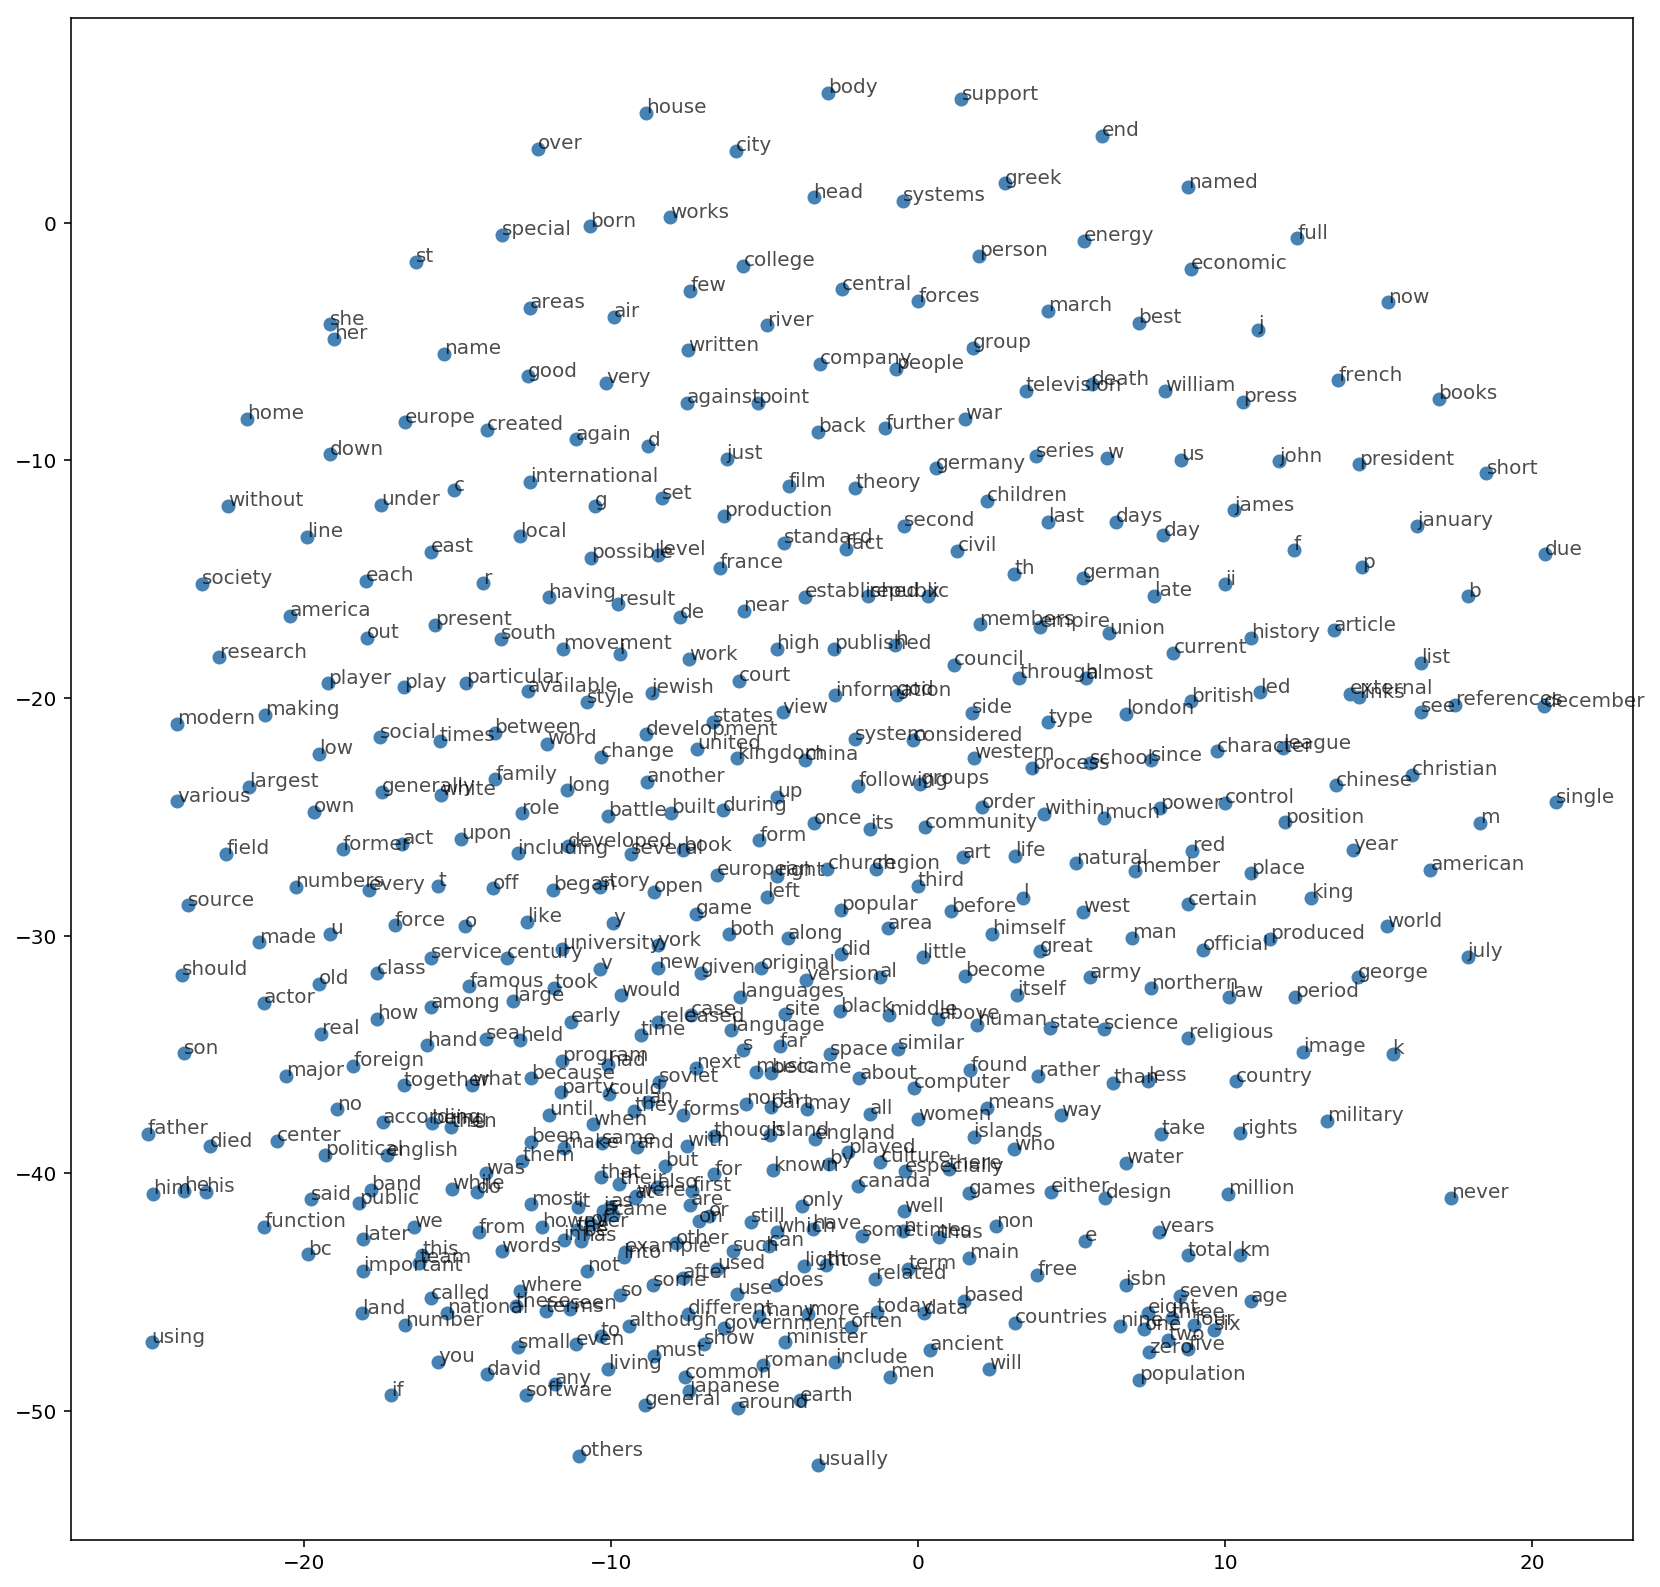

In [22]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)